# Titanic Kaggle

Worked example for the Titanic Kaggle competition: https://www.kaggle.com/c/titanic

1. Import & look at data
2. Prepare categorical data
3. Prepare numerical data
4. Create model
5. Train model
6. ???
7. Profit

## Utitlity functions

In [2]:
from keras import models
from keras import layers
from keras import backend

In [3]:
# Plot model history more easily

import matplotlib.pyplot as plt

def plot_this(training, validation, label):
    
    epochs = range(1, len(training) + 1)
    
    plt.clf() # clear out old
    
    plt.xkcd() # make look like xkcd
    
    trim = 10 # remove first 10 data points

    plt.plot(epochs[trim:], training[trim:], 'b', label=('Training '+label))
    plt.plot(epochs[trim:], validation[trim:], 'g', label=('Validation '+label))
    plt.title('Model ' + label)
    plt.xlabel('Epochs')
    plt.ylabel(label)
    plt.legend()

    plt.show()

In [4]:
# smooth out the points by some factor (0.5 = rough, 0.99 = smooth)

def smooth_curve(points, factor=0.75):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

## Let's begin!

In [5]:
import pandas as pd 

titanic_path = '../../titanic/train.csv'

df = pd.read_csv(titanic_path, quotechar='"')

In [6]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Keep only desired rows and rearrange for easier view:

In [7]:
preferredOrder = ['Sex', 'Pclass', 'Cabin', 'Embarked', 'SibSp', 'Parch', 'Age', 'Fare', 'Survived']
df = df[preferredOrder]

In [8]:
df.head(5)

,Sex,Pclass,Cabin,Embarked,SibSp,Parch,Age,Fare,Survived
0,male,3,NaN,S,1,0,22.0,7.2500,0
1,female,1,C85,C,1,0,38.0,71.2833,1
2,female,3,NaN,S,0,0,26.0,7.9250,1
3,female,1,C123,S,1,0,35.0,53.1000,1
4,male,3,NaN,S,0,0,35.0,8.0500,0


## Prepare categorical data

We will use these 4 as categories:
 - Sex
 - Pclass
 - Cabin
 - Embarked

In [9]:
categorical_data = preferredOrder[:4]
categorical_data

['Sex', 'Pclass', 'Cabin', 'Embarked']

`Cabin` values need to be placed into categories.

In [10]:
df['Cabin'].values[:20]

array([nan, 'C85', nan, 'C123', nan, nan, 'E46', nan, nan, nan, 'G6',
       'C103', nan, nan, nan, nan, nan, nan, nan, nan], dtype=object)

In [11]:
def cleanCabin(el):
    if isinstance(el, str):
        return el[:1]
    else:
        return '0'
df['Cabin'] = df['Cabin'].apply(cleanCabin)
df['Cabin'].values[:20]

array(['0', 'C', '0', 'C', '0', '0', 'E', '0', '0', '0', 'G', 'C', '0',
       '0', '0', '0', '0', '0', '0', '0'], dtype=object)

Keras has `to_categorical` method for **one hot encoding** of data, but it requires natural number input.

We will create our own conversion

In [12]:
def convert_to_natural_number(x, temp_dict):
    if x in temp_dict:
        return temp_dict[x]
    else:
        temp_dict[x] = temp_dict['curr_count']
        temp_dict['curr_count'] += 1
        return temp_dict[x]


In [13]:
def categorical_column_to_number(col):
    temp_dict = temp_dict = {'curr_count': 0}
    df[col] = df[col].apply(convert_to_natural_number, args=(temp_dict,))

In [14]:
df[categorical_data].head(10)

,Sex,Pclass,Cabin,Embarked
0,male,3,0,S
1,female,1,C,C
2,female,3,0,S
3,female,1,C,S
4,male,3,0,S
5,male,3,0,Q
6,male,1,E,S
7,male,3,0,S
8,female,3,0,S
9,female,2,0,C


In [15]:
for col in categorical_data:
    categorical_column_to_number(col)

In [16]:
df[categorical_data].head(10)

,Sex,Pclass,Cabin,Embarked
0,0,0,0,0
1,1,1,1,1
2,1,0,0,0
3,1,1,1,0
4,0,0,0,0
5,0,0,0,2
6,0,1,2,0
7,0,0,0,0
8,1,0,0,0
9,1,2,0,1


Now we are ready to convert data to _one hot encoding_

In [17]:
newDF = pd.DataFrame()
newDF = df[categorical_data]
    
for col in categorical_data:
    one_hot = pd.get_dummies(df[col])
    one_hot = one_hot.add_prefix(col)
    newDF = newDF.join(one_hot) #adding onehot encoded columns to dataframe
    newDF = newDF.drop(col, 1) #deleting categorical column

In [18]:
newDF.head(5)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin3,Cabin4,Cabin5,Cabin6,Cabin7,Cabin8,Embarked0,Embarked1,Embarked2,Embarked3
0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [19]:
newDF.shape

(891, 18)

In [20]:
print(list(newDF))

['Sex0', 'Sex1', 'Pclass0', 'Pclass1', 'Pclass2', 'Cabin0', 'Cabin1', 'Cabin2', 'Cabin3', 'Cabin4', 'Cabin5', 'Cabin6', 'Cabin7', 'Cabin8', 'Embarked0', 'Embarked1', 'Embarked2', 'Embarked3']


Some columns have too-few elements and we'll drop them - you can't learn from too-few examples (they may be flukes and not statistically representative)

In [21]:
print('Column   \ttotal entrties')
print('-------------------------------')
for col in list(newDF):
    total = newDF[col].sum()
    print(col,':    ', '\t', total, sep='', end='')
    if (total < 10):
        newDF = newDF.drop([col], axis=1)
        print('\t<-- dropped', end='')
    print()

Column   	total entrties
-------------------------------
Sex0:    	577
Sex1:    	314
Pclass0:    	491
Pclass1:    	216
Pclass2:    	184
Cabin0:    	687
Cabin1:    	59
Cabin2:    	32
Cabin3:    	4	<-- dropped
Cabin4:    	33
Cabin5:    	15
Cabin6:    	47
Cabin7:    	13
Cabin8:    	1	<-- dropped
Embarked0:    	644
Embarked1:    	168
Embarked2:    	77
Embarked3:    	2	<-- dropped


In [22]:
newDF.head(5)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin4,Cabin5,Cabin6,Cabin7,Embarked0,Embarked1,Embarked2
0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0
1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0
2,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0
3,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0
4,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0


In [23]:
one_hot_columns = list(newDF)
print(one_hot_columns)

['Sex0', 'Sex1', 'Pclass0', 'Pclass1', 'Pclass2', 'Cabin0', 'Cabin1', 'Cabin2', 'Cabin4', 'Cabin5', 'Cabin6', 'Cabin7', 'Embarked0', 'Embarked1', 'Embarked2']


In [24]:
result = pd.concat([newDF, df], axis=1, join_axes=[newDF.index])

In [25]:
result = result.drop(categorical_data, axis=1)

In [26]:
result.head(5)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin4,Cabin5,Cabin6,Cabin7,Embarked0,Embarked1,Embarked2,SibSp,Parch,Age,Fare,Survived
0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,22.0,7.2500,0
1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,38.0,71.2833,1
2,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,26.0,7.9250,1
3,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,35.0,53.1000,1
4,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,35.0,8.0500,0


## Built categorical model

In [27]:
result[one_hot_columns].shape

(891, 15)

In [104]:
# backend.clear_session()

model_cat = models.Sequential()
model_cat.add(layers.Dense(64, activation='relu', input_shape=(15,)))
model_num.add(layers.Dense(32, activation='relu'))
model_num.add(layers.Dense(16, activation='relu'))
model_num.add(layers.Dense(8, activation='relu'))
model_num.add(layers.Dense(4, activation='relu'))
model_num.add(layers.Dense(8, activation='relu'))
model_num.add(layers.Dense(4, activation='relu'))
model_num.add(layers.Dense(8, activation='relu'))
model_num.add(layers.Dense(32, activation='relu'))
model_cat.add(layers.Dense(1))
model_cat.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model_cat.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 64)                1024      
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 65        
Total params: 1,089
Trainable params: 1,089
Non-trainable params: 0
_________________________________________________________________


In [105]:
result = result.sample(frac=1)

In [106]:
x_data = result[one_hot_columns]
y_data = result['Survived']

cutoff = round(0.8 * len(x_data))

x_train = x_data[:cutoff]
y_train = y_data[:cutoff]

x_validation = x_data[cutoff:]
y_validation = y_data[cutoff:]

In [107]:
result.head(5)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin4,Cabin5,Cabin6,Cabin7,Embarked0,Embarked1,Embarked2,SibSp,Parch,Age,Fare,Survived
29,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.00,0.0,0.0000,0.015412,0
231,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.00,0.0,0.3625,0.015176,0
722,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0.00,0.0,0.4250,0.025374,0
333,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.25,0.0,0.2000,0.035134,0
48,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0.25,0.0,0.0000,0.042315,0


## Train categorical

In [108]:
history_cat = model_cat.fit(x_train,
                            y_train,
                            epochs=600,
                            batch_size=len(x_train),
                            verbose=0,
                            validation_data=(x_validation, y_validation))

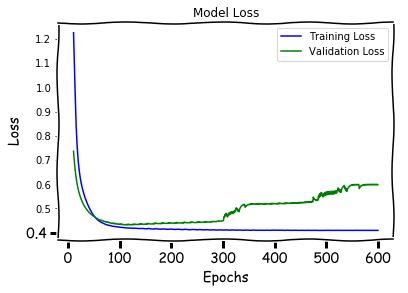

In [109]:
loss_cat = smooth_curve(history_cat.history['loss'])
val_loss_cat = smooth_curve(history_cat.history['val_loss'])



plot_this(loss_cat, val_loss_cat, 'Loss')

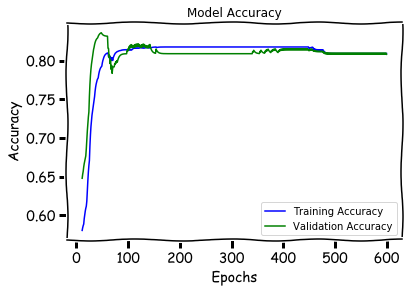

In [110]:
accuracy_cat = smooth_curve(history_cat.history['acc'])
val_acc_cat = smooth_curve(history_cat.history['val_acc'])

plot_this(accuracy_cat, val_acc_cat, 'Accuracy')

## Prepare numerical data

We will use these 4 as numbers:
 - SibSp (# of **sib**lings / # of **sp**ouses)
 - Parch (# of **par**ent / # of **ch**ildren)
 - Age
 - Fare

In [28]:
numerical_data = preferredOrder[4:8]
numerical_data

['SibSp', 'Parch', 'Age', 'Fare']

In [29]:
import math

def normalize(x, colMax):
    if math.isnan(x):
        return 0
    if isinstance(x, float):
        return x / colMax
    elif isinstance(x, int):
        return float(x) / colMax
    else:
        return 0

In [30]:
def applyNormalize(col):
    column_max = result[col].max()
    result[col] = result[col].apply(normalize, args=(column_max,))

In [31]:
for col in numerical_data:
    applyNormalize(col)

In [32]:
result[numerical_data].head(3)

,SibSp,Parch,Age,Fare
0,0.125,0.0,0.275,0.014151
1,0.125,0.0,0.475,0.139136
2,0.000,0.0,0.325,0.015469


In [33]:
result[numerical_data].describe()

,SibSp,Parch,Age,Fare
count,891.000000,891.000000,891.000000,891.000000
mean,0.065376,0.063599,0.297491,0.062858
std,0.137843,0.134343,0.219951,0.096995
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.075000,0.015440
50%,0.000000,0.000000,0.300000,0.028213
75%,0.125000,0.000000,0.437500,0.060508
max,1.000000,1.000000,1.000000,1.000000


Notice that max is now 1

## Build model

In [34]:
result.head(10)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin4,Cabin5,Cabin6,Cabin7,Embarked0,Embarked1,Embarked2,SibSp,Parch,Age,Fare,Survived
0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.125,0.000000,0.2750,0.014151,0
1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0.125,0.000000,0.4750,0.139136,1
2,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0.000,0.000000,0.3250,0.015469,1
3,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0.125,0.000000,0.4375,0.103644,1
4,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.000,0.000000,0.4375,0.015713,0
5,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0.000,0.000000,0.0000,0.016510,0
6,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0.000,0.000000,0.6750,0.101229,0
7,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.375,0.166667,0.0250,0.041136,0
8,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0.000,0.333333,0.3375,0.021731,1
9,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0.125,0.000000,0.1750,0.058694,1


**Randomize the order of all the rows**

_this is important because the original data may not be (and in this case is not) random_

In [35]:
result = result.sample(frac=1)

Split validation & training data

In [49]:
x_data = result[numerical_data]
y_data = result['Survived']

cutoff = round(0.8 * len(x_data))

x_train = x_data[:cutoff]
y_train = y_data[:cutoff]

x_validation = x_data[cutoff:]
y_validation = y_data[cutoff:]

In [93]:
# backend.clear_session()

model_num = models.Sequential()
model_num.add(layers.Dense(64, activation='relu', input_shape=(4,)))
model_num.add(layers.Dense(32, activation='relu'))
model_num.add(layers.Dense(16, activation='relu'))
model_num.add(layers.Dense(8, activation='relu'))
model_num.add(layers.Dense(4, activation='relu'))
model_num.add(layers.Dense(8, activation='relu'))
model_num.add(layers.Dense(4, activation='relu'))
model_num.add(layers.Dense(32, activation='relu'))

model_num.add(layers.Dense(1))
model_num.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model_num.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_29 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_30 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_31 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_32 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_33 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 36        
__________

## Train

In [94]:
history_num = model_num.fit(x_train,
                            y_train,
                            epochs=300,
                            batch_size=len(x_train),
                            verbose=0,
                            validation_data=(x_validation, y_validation))

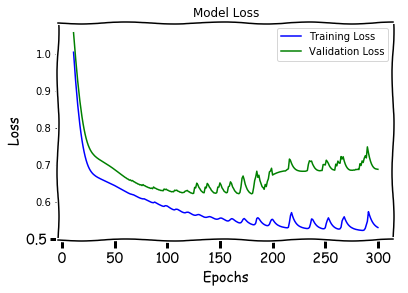

In [95]:
loss_num = smooth_curve(history_num.history['loss'])
val_loss_num = smooth_curve(history_num.history['val_loss'])

plot_this(loss_num, val_loss_num, 'Loss')

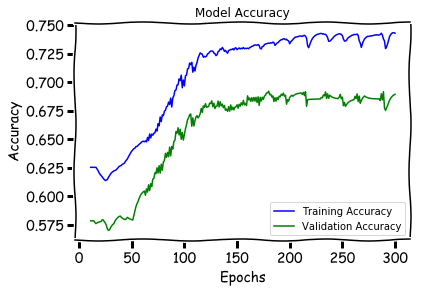

In [96]:
accuracy_num = smooth_curve(history_num.history['acc'])
val_acc_num = smooth_curve(history_num.history['val_acc'])

plot_this(accuracy_num, val_acc_num, 'Accuracy')

## Merge two models

In [72]:
model_cat.trainable = False
model_cat.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 36)                576       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 296       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 913
Trainable params: 0
Non-trainable params: 913
_________________________________________________________________


In [73]:
model_num.trainable = True
model_num.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total para

In [74]:
result.shape

(891, 20)

In [41]:
x_cat_all = result[one_hot_columns]
x_num_all = result[numerical_data]
y_data_all = result['Survived']

cutoff = round(0.8 * len(x_cat_all))

x_cat = x_cat_all[:cutoff]
x_num = x_num_all[:cutoff]
y_train = y_data_all[:cutoff]

x_cat_val = x_cat_all[cutoff:]
x_num_val = x_num_all[cutoff:]
y_validation = y_data_all[cutoff:]

## ACTUAL SUCCESS

In [36]:
from keras import Input
from keras.layers import concatenate

In [53]:
# backend.clear_session()

left = Input(shape=(15,))
l1 = layers.Dense(64, activation='relu')(left)
l2 = layers.Dense(32, activation='relu')(l1)
l3 = layers.Dense(16, activation='relu')(l2)
l4 = layers.Dense(8, activation='relu')(left_hidden3)
l5 = layers.Dense(4, activation='relu')(left_hidden4)
left_output = layers.Dense(1, activation='sigmoid')(left_hidden5)

right = Input(shape=(4,))
right_hidden1 = layers.Dense(64, activation='relu')(right)
right_hidden2 = layers.Dense(32, activation='relu')(right_hidden1)
right_hidden3 = layers.Dense(16, activation='relu')(right_hidden2)
right_hidden4 = layers.Dense(8, activation='relu')(right_hidden3)
right_hidden5 = layers.Dense(4, activation='relu')(right_hidden4)
right_output = layers.Dense(1, activation='sigmoid')(right_hidden5)

merge = concatenate([left_output, right_output])
hidden1 = layers.Dense(8, activation='relu')(merge)
hidden2 = layers.Dense(4, activation='relu')(hidden1)
output = layers.Dense(1, activation='sigmoid')(hidden2)

model_new = models.Model(inputs=[left, right], outputs=output)

In [54]:
model_new.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
model_new.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 64)           1024        input_3[0][0]                    
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 64)           320         input_4[0][0]                    
__________________________________________________________________________________________________
dense_15 (

In [56]:
x_cat_val.shape

(178, 15)

In [57]:
history_final = model_new.fit([x_cat, x_num],
                                y_train,
                                epochs=100,
                                verbose=0,
                                batch_size=128,
                                validation_data=([x_cat_val, x_num_val], y_validation))

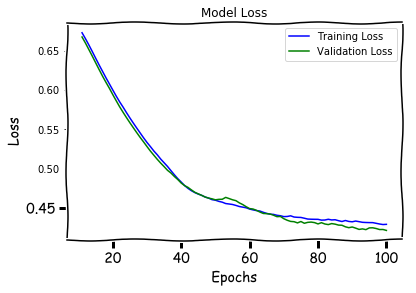

In [58]:
train = smooth_curve(history_final.history['loss'])
validation = smooth_curve(history_final.history['val_loss'])

plot_this(train, validation, 'Loss')

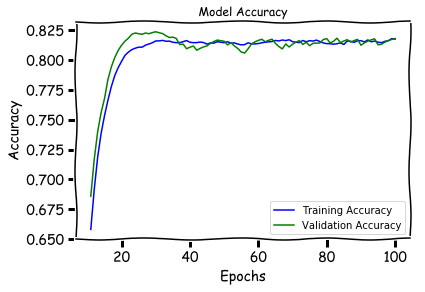

In [59]:
train = smooth_curve(history_final.history['acc'])
validation = smooth_curve(history_final.history['val_acc'])

plot_this(train, validation, 'Accuracy')

## Archived

In [70]:
from keras.utils import to_categorical

In [71]:
for col in categorical_data:
    print(col)
    lol = (to_categorical(df[col]))
    print(lol[:5])

Sex
[[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]
Pclass
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]
Cabin
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]]
Embarked
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]]


## UNUSED -- likely bad code

In [163]:
import keras

backend.clear_session()

input1 = keras.layers.Input(shape=(15,))
x1 = keras.layers.Dense(8, activation='relu')(input1)

input2 = keras.layers.Input(shape=(4,))
x2 = keras.layers.Dense(8, activation='relu')(input2)

added = keras.layers.Add()([x1, x2])  # equivalent to added = keras.layers.add([x1, x2])

out = keras.layers.Dense(4)(added)
model = keras.models.Model(inputs=[input1, input2], outputs=out)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            128         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 8)            40          input_2[0][0]                    
__________________________________________________________________________________________________
add_1 (Add

In [53]:
from keras import Input

In [54]:
cat_input = Input(shape=(None,), dtype='int32', name='text')

In [55]:
x = Input(shape=(15,36))

In [56]:
y = model_cat(x)

In [57]:
x = Input(shape=(None,None))

In [58]:
y = model_num(x)

AssertionError: 

In [147]:
full_cat_model = layers.add(model_cat.output)(cat_input)

ValueError: A merge layer should be called on a list of inputs.

In [59]:
num_input = Input(shape=(None,), dtype='int32', name='text')
cat_input = Input(shape=(None,), dtype='int32', name='text')

In [61]:
# backend.clear_session()

model_final = models.Sequential()
model_final.add(layers.Dense(16, activation='relu', input_shape=(20,)))
model_final.add(layers.Dropout(0.1))
model_final.add(layers.Dense(16, activation='relu'))
model_final.add(layers.Dropout(0.1))
model_final.add(layers.Dense(8, activation='relu'))
model_final.add(layers.Dropout(0.1))
model_final.add(layers.Dense(1))
model_final.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 16)                336       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 9         
Total para